# Introduction to VirES for Swarm

> This notebook requires hapiclient, hapiplot, and viresclient. To install them, you can use:  
> ```
> pip install hapiclient hapiplot viresclient
> ```

> Usage of viresclient requires an account at https://vires.services. You can also run this notebook on the VirES JupyterHub at https://vre.vires.services

Hopefully you have already seen the introduction to the [Heliophysics Application Programmer’s Interface (HAPI)](http://hapi-server.org/) (see the notebooks under `summer-school/hapi-tutorial`). Here we give a short introduction to accessing data from Swarm, firstly via the HAPI interface and secondly through the VirES interface (which is more complicated but has more features). Both interfaces allow you to access the same data from the same server, just in different ways. This tutorial will be of interest to you if you need data and models from Swarm specifically.

VirES is a data retrieval and visualisation system supporting ESA's Swarm mission. For more information, see:
- Service splash page and graphical interface: https://vires.services
    - HAPI splash page: https://vires.services/hapi
- Notebook guide: https://notebooks.vires.services
- viresclient package: https://viresclient.readthedocs.io
- Swarm mission webpages: https://earth.esa.int/eogateway/missions/swarm

## Data retrieved over HAPI

Just as with any HAPI-enabled server, we can retrieve data by specifying a `dataset`, particular `parameters` from within that dataset, and the `start` and `stop` times.

This example fetches from the primary data product, the Magnetic Low Resolution (`MAGx_LR`) from Swarm Alpha. This contains two key parameters:
- `F`, the intensity of the magnetic field (scalar) measured by the [Absolute Scalar Magnetometer (ASM)](https://earth.esa.int/eogateway/instruments/asm) instrument
- `B_NEC`, the vector magnetic field in the NEC (North, East, Centre) reference frame, measured by the [Vector Field Magnetometer (VFM)](https://earth.esa.int/eogateway/instruments/vfm) and calibrated by the ASM measurements

In [1]:
from hapiclient import hapi

In [2]:
server     = 'https://vires.services/hapi';
dataset    = 'SW_OPER_MAGA_LR_1B';
parameters = 'Latitude,Longitude,F,B_NEC'; 
start      = '2022-01-01T00:00:00Z';
stop       = '2022-01-01T03:00:00Z';

data, meta = hapi(server, dataset, parameters, start, stop)

Remember that you can use the tool at http://hapi-server.org/servers/ to generate such code snippets (and more).

In [3]:
data

array([(b'2022-01-01T00:00:00.000Z', -10.7018412,   5.5274837, 24691.5537, [ 16500.7277,  -2005.4204, -18258.8947]),
       (b'2022-01-01T00:00:01.000Z', -10.766143 ,   5.5263728, 24684.8225, [ 16462.9897,  -2009.6696, -18283.4302]),
       (b'2022-01-01T00:00:02.000Z', -10.8304444,   5.5252632, 24678.0576, [ 16425.2334,  -2013.914 , -18307.7783]),
       ...,
       (b'2022-01-01T02:59:57.000Z',  13.927745 , -40.7831502, 25694.2203, [ 23392.8442,  -6292.2198,   8565.0539]),
       (b'2022-01-01T02:59:58.000Z',  13.8633667, -40.7841815, 25670.7164, [ 23387.436 ,  -6296.9193,   8505.6043]),
       (b'2022-01-01T02:59:59.000Z',  13.7989885, -40.7852146, 25647.262 , [ 23381.958 ,  -6301.5792,   8446.2844])],
      dtype=[('Timestamp', 'S24'), ('Latitude', '<f8'), ('Longitude', '<f8'), ('F', '<f8'), ('B_NEC', '<f8', (3,))])

The data is returned as a [NumPy Structured Array](https://numpy.org/doc/stable/user/basics.rec.html), allowing you to extract the particular NumPy arrays for each parameter with, e.g., `data["F"]`, `data["Timestamp"]`. Note that `B_NEC` is a vector and so is represented as a 2D array:

In [4]:
data["B_NEC"]

array([[ 16500.7277,  -2005.4204, -18258.8947],
       [ 16462.9897,  -2009.6696, -18283.4302],
       [ 16425.2334,  -2013.914 , -18307.7783],
       ...,
       [ 23392.8442,  -6292.2198,   8565.0539],
       [ 23387.436 ,  -6296.9193,   8505.6043],
       [ 23381.958 ,  -6301.5792,   8446.2844]])

In [5]:
print("F shape:", data["F"].shape)
print("B_NEC shape:", data["B_NEC"].shape)

F shape: (10800,)
B_NEC shape: (10800, 3)


You will probably want to convert the time strings to Python `datetime` objects. You can do this with the `hapitime2datetime` function:

In [6]:
from hapiclient import hapitime2datetime

hapitime2datetime(data["Timestamp"])

array([datetime.datetime(2022, 1, 1, 0, 0, tzinfo=<UTC>),
       datetime.datetime(2022, 1, 1, 0, 0, 1, tzinfo=<UTC>),
       datetime.datetime(2022, 1, 1, 0, 0, 2, tzinfo=<UTC>), ...,
       datetime.datetime(2022, 1, 1, 2, 59, 57, tzinfo=<UTC>),
       datetime.datetime(2022, 1, 1, 2, 59, 58, tzinfo=<UTC>),
       datetime.datetime(2022, 1, 1, 2, 59, 59, tzinfo=<UTC>)],
      dtype=object)

Such data can be previewed using the `hapiplot` package, which takes both the `data` and `meta` (metadata) as input in order to label the plots appropriately. You may like to try:

```python
from hapiplot import hapiplot

hapiplot(data, meta)
```

`hapiplot` uses `matplotlib` to auto-generate reasonable plots of the data. You can use `matplotlib` directly:

```python
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(hapitime2datetime(data["Timestamp"]), data["F"])
```

### Exercise

Try the matplotlib example yourself
- Can you extend it to place the `B_NEC` parameter on the lower plot?
- Can you use the contents of `meta` to label the plot?
- Advanced: Can you reformat the times on the x-axis?

## More data from VirES

To access the full features of VirES (not just the HAPI interface), you will need to register at https://vires.services. Once you have an account, you can proceed to use the `viresclient` package to access data through Python.

On first usage, you should be prompted to enter an access token as shown below. If that doesn't work, you can also use:
```python
from viresclient import set_token
set_token("https://vires.services/ows")
```
or refer to [the documentation](https://viresclient.readthedocs.io/en/latest/config_details.html). The access token is stored in a file in your home directory (`~/.viresclient.ini`) so you only need to enter this once.

Access tokens are configured at https://vires.services/accounts/tokens/ (if this redirects you to the main page, login and then try the link again).

In [7]:
from viresclient import SwarmRequest

In [8]:
request = SwarmRequest()

Access token not found.


Setting access token for https://vires.services/ows... Generate a token at https://vires.services/accounts/tokens/

Enter token: ································


Token saved for https://vires.services/ows


We can now proceed to fetch the same data as we used earlier over HAPI:

In [9]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(measurements=["F", "B_NEC"])
data = request.get_between("2022-01-01T00:00:00Z", "2022-01-01T03:00:00Z")
data

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.707MB)

The data is now accessible through this object (assigned to `data`) that has some different methods to load it into memory. The data is actually stored on disk as a temporary file, then you can choose to load it as either as a [pandas DataFrame](https://pandas.pydata.org/docs/) or [xarray Dataset](https://docs.xarray.dev/).

In [10]:
data?

Type:        ReturnedData
String form:
viresclient ReturnedData object of type cdf
Save it to a file with .to_file('filename')
Load it as a pandas dataframe with .as_dataframe()
Load it as an xarray dataset with .as_xarray()
File:        ~/mambaforge/envs/vires-tutorial/lib/python3.10/site-packages/viresclient/_data_handling.py
Docstring:  
Flexible object for working with data returned from the server

Holds a list of ReturnedDataFile objects under self.contents

Example usage::

    ...
    data = request.get_between(..., ...)
    data.sources
    data.range_filters
    data.magnetic_models
    data.as_xarray()
    data.as_xarray_dict()
    data.as_dataframe(expand=True)
    data.to_file()


In [11]:
# (Use expand=True to separate the vector, B_NEC, into different columns)
df = data.as_dataframe(expand=True)
df.head()

F   Latitude Spacecraft  Longitude      Radius  \
Timestamp                                                                      
2022-01-01 00:00:00  24691.5537 -10.701841          A   5.527484  6809839.03   
2022-01-01 00:00:01  24684.8225 -10.766143          A   5.526373  6809847.97   
2022-01-01 00:00:02  24678.0576 -10.830444          A   5.525263  6809856.91   
2022-01-01 00:00:03  24671.2615 -10.894746          A   5.524155  6809865.83   
2022-01-01 00:00:04  24664.4253 -10.959047          A   5.523048  6809874.74   

                        B_NEC_N    B_NEC_E     B_NEC_C  
Timestamp                                               
2022-01-01 00:00:00  16500.7277 -2005.4204 -18258.8947  
2022-01-01 00:00:01  16462.9897 -2009.6696 -18283.4302  
2022-01-01 00:00:02  16425.2334 -2013.9140 -18307.7783  
2022-01-01 00:00:03  16387.4797 -2018.3884 -18331.9555  
2022-01-01 00:00:04  16349.7951 -2022.9964 -18355.8211

In [12]:
ds = data.as_xarray()
ds

<xarray.Dataset>
Dimensions:     (Timestamp: 10800, NEC: 3)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2022-01-01 ... 2022-01-01T02:59:59
  * NEC         (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    F           (Timestamp) float64 2.469e+04 2.468e+04 ... 2.567e+04 2.565e+04
    Latitude    (Timestamp) float64 -10.7 -10.77 -10.83 ... 13.93 13.86 13.8
    Longitude   (Timestamp) float64 5.527 5.526 5.525 ... -40.78 -40.78 -40.79
    Radius      (Timestamp) float64 6.81e+06 6.81e+06 ... 6.806e+06 6.806e+06
    B_NEC       (Timestamp, NEC) float64 1.65e+04 -2.005e+03 ... 8.446e+03
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20220101T000000_20220101T235959_050...
    MagneticModels:  []
    RangeFilters:    []

Note that there are two obvious first advantages to using xarray over pandas:
- N-dimensional data can be represented naturally (e.g. with `B_NEC`)
- Metadata is contained within the object. Click the icons at the right of the HTML representation above, or access programmatically like:

In [13]:
ds["F"].attrs

{'units': 'nT', 'description': 'Magnetic field intensity'}

### Exercise

- Verify that the `F` data from the earlier HAPI example is the same as that loaded through viresclient (either through pandas or xarray, or both!).  
  Hint: look up `numpy.array_equal`
- Try the built-in plotting tools of pandas and xarray to generate matplotlib plots:
  ```python
  df.plot(y="F")
  ds["B_NEC"].plot.line(x="Timestamp")
  ```
  Can you plot `B_NEC` against Latitude?
- Browse through the demos at [Swarm Notebooks](https://notebooks.vires.services/notebooks/03a1_demo-magx_lr_1b) and fetch some other data you are interested in. Perhaps the FAC (Field-Aligned Currents) from the `SW_OPER_FACATMS_2F` collection.

## Data and *models* from VirES

The VirES server has the capability to evaluate near-Earth geomagnetic field models on-demand. This means one can strip away the effect of such a model, obtaining the *data-model residuals*. For example, here we specify the IGRF model together with our request. We can also specify *auxiliary* variables such as the `OrbitNumber` and `QDLat` (Quasi-Dipole Magnetic Latitude).

Note: the below examples use xarray. You may prefer to switch these to pandas if you are not familiar with xarray, or to replicate the equivalent using the numpy arrays directly (extracting them with, e.g., `B_NEC = ds["B_NEC"].values`).

In [14]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F", "B_NEC"],
    models=["IGRF"],
    auxiliaries=["OrbitNumber", "QDLat"]
)
data = request.get_between("2022-01-01T00:00:00Z", "2022-01-01T03:00:00Z")
ds = data.as_xarray()
ds

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (1.184MB)

<xarray.Dataset>
Dimensions:      (Timestamp: 10800, NEC: 3)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2022-01-01 ... 2022-01-01T02:59:59
  * NEC          (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft   (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    B_NEC_IGRF   (Timestamp, NEC) float64 1.652e+04 -1.977e+03 ... 8.425e+03
    F            (Timestamp) float64 2.469e+04 2.468e+04 ... 2.567e+04 2.565e+04
    OrbitNumber  (Timestamp) int32 45611 45611 45611 45611 ... 45613 45613 45613
    Longitude    (Timestamp) float64 5.527 5.526 5.525 ... -40.78 -40.78 -40.79
    Latitude     (Timestamp) float64 -10.7 -10.77 -10.83 ... 13.93 13.86 13.8
    QDLat        (Timestamp) float64 -22.54 -22.6 -22.66 ... 9.908 9.841 9.774
    Radius       (Timestamp) float64 6.81e+06 6.81e+06 ... 6.806e+06 6.806e+06
    B_NEC        (Timestamp, NEC) float64 1.65e+04 -2.005e+03 ... 8.446e+03
    F_IGRF       (Timestamp) float64 2.471e+04 2.47e+04 ... 2.57e+04 2.567e+04
Attributes:
    Sources:         ['SW_OPER_AUXAORBCNT_20131122T000000_20220510T000000_000...
    MagneticModels:  ['IGRF = IGRF(max_degree=13,min_degree=1)']
    RangeFilters:    []

The dataset contains both the measurements, `B_NEC`, and the model predictions, `B_NEC_IGRF`. We can easily add the residuals to the dataset:

In [15]:
ds["B_NEC_res_IGRF"] = ds["B_NEC"] - ds["B_NEC_IGRF"]
ds["B_NEC_res_IGRF"].attrs = {"units": "nT"}

Now lets compare the measurements and the residuals....

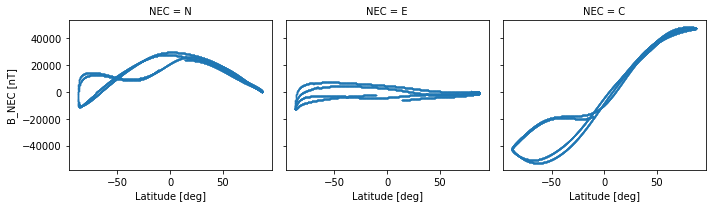

In [16]:
ds.plot.scatter(x="Latitude", y="B_NEC", col="NEC", s=0.10)

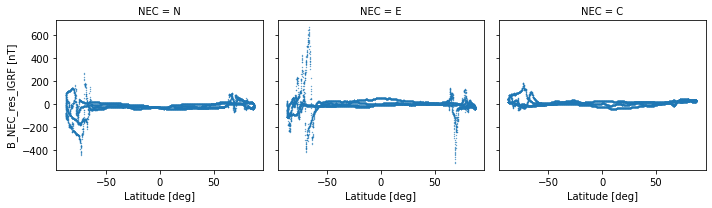

In [17]:
ds.plot.scatter(x="Latitude", y="B_NEC_res_IGRF", col="NEC", s=0.10)

### Exercise

- Can you interpret the signals shown in these two figures? The first figure, in terms of the dipolar main field from Earth's core, and the second figure in terms of the ionospheric and magnetospheric fields.
- Try generating different kinds of plots from this dataset. How about replacing `Latitude` with `QDLat`? How might you use `OrbitNumber` to only plot a given orbit or split them over different plots?
- Take a look at [Geomagnetic Model Residuals](https://notebooks.vires.services/notebooks/04a1_geomag-models-vires) and see how you might use a more complex model such as *CHAOS* which, beside the core field, also includes the crustal and large-scale magnetospheric field